In [39]:
import os
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import torchvision
import torch.nn as nn
import torch.functional as F
import torch.utils.data
import torchvision.datasets as dset
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

In [40]:
if not os.path.exists("data"):
    os.mkdir("data")

In [41]:
train_dataset = dset.MNIST("./data/mnist/", train = True, transform=transforms.Compose([
    transforms.ToTensor()
]))
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128)
test_dataset = dset.MNIST("./data/mnist/", train = False, transform=transforms.Compose([
    transforms.ToTensor()
]))
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

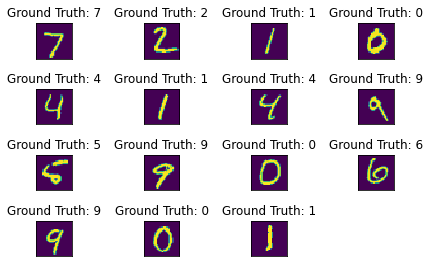

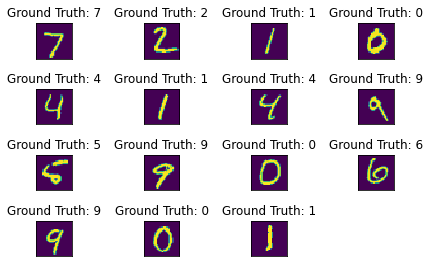

In [42]:
data = enumerate(test_data_loader)
_, (example_data, target) = data.__next__()
fig = plt.figure()
for i in range(15):
    plt.subplot(4,4,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='viridis', interpolation='none')
    plt.title(f"Ground Truth: {target[i]}")
    plt.xticks([])
    plt.yticks([])
fig

### Architecture Definition

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self, code_size:int):
        self.code_size = code_size
        super(AutoEncoder, self).__init__()
        self.encoder =  nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 2)
        )
        
        self.decoder =  nn.Sequential(
            nn.Linear(2, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent_space = self.encoder(x)
        op = self.decoder(latent_space)
        return torch.reshape(op, (-1, 1, 28, 28))

In [6]:
writer = SummaryWriter()
def train(model: nn.Module, data: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer, epochs = 10, device = 'cpu'):
    loss_fn = nn.MSELoss()
    model.to(device)
    for epoch in range(epochs):
        i = 0
        error = 0
        for inp, label in data:
            inp = inp.to(device)
            optimizer.zero_grad()
            output = model(inp)
            loss = loss_fn(inp, output.to(device))
            loss.backward()
            optimizer.step()
            error += torch.linalg.norm(loss).item()
            i += 1
        writer.add_scalar("Loss/train", error / i, epoch + 1)
        print(f"Error for epoch {epoch + 1}: {error / i}")

    return model

In [11]:
# test for dimemsion
_, (example_data, target) = data.__next__()
torch.flatten(example_data, start_dim=1).shape

torch.Size([64, 784])

### Torch Config and Loss functions

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
latent_dims = 2
autoencoder_model_name = "models/autoencoder.pth"
model = AutoEncoder(latent_dims)
model.load_state_dict(torch.load(autoencoder_model_name, map_location = device))
# betas for adam
beta_1 = 0.5
beta_2 = 0.999
# model = train(model, data_loader, optimizer, device=device)

cpu


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002, weight_decay=1e-5)
model = train(model, train_data_loader, optimizer, device=device, epochs=20)

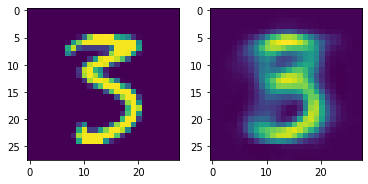

In [54]:
_, (image, label) = data.__next__()
plt.subplot(1, 2, 1)
plt.imshow(image[0][0])
plt.subplot(1, 2, 2)
model.to(device=device)
plt.imshow(model(image.to(device)).to('cpu').detach().numpy()[0][0])

In [137]:
# save model
torch.save(model.state_dict(), autoencoder_model_name)

### Variational Autoencoder

In [43]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, code_size:int):
        self.code_size = code_size
        super(VariationalAutoEncoder, self).__init__()
        self.encoder =  nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
        )
        self.mu_linear = nn.Linear(12, code_size)
        self.sigma_linear = nn.Linear(12, code_size)
        
        self.decoder =  nn.Sequential(
            nn.Linear(2, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )
        self.N = torch.distributions.Normal(0, 1)   

    def forward(self, x):
        x = self.encoder(x)
        latent_space_mean = self.mu_linear(x)
        latent_space_sigma = self.sigma_linear(x)
        z = latent_space_mean + latent_space_sigma * self.N.sample(latent_space_mean.shape)
        # TODO: https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians
        self.kl = (latent_space_sigma ** 2 + latent_space_mean ** 2 - torch.log(latent_space_sigma) - 1/2).sum()
        op = self.decoder(z)
        return torch.reshape(op, (-1, 1, 28, 28))

In [49]:
writer = SummaryWriter()
def train_vae(model: nn.Module, data: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer, epochs = 10, device = 'cpu'):
    loss_fn = nn.MSELoss()
    model.to(device)
    for epoch in range(epochs):
        i = 0
        error = 0
        for inp, label in data:
            inp = inp.to(device)
            optimizer.zero_grad()
            output = model(inp)
            loss = loss_fn(inp, output.to(device)) + model.kl
            loss.backward()
            optimizer.step()
            error += torch.linalg.norm(loss).item()
            i += 1
        writer.add_scalar("Loss/train", error / i, epoch + 1)
        print(f"Error for epoch {epoch + 1}: {error / i}")

    return model

In [52]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
latent_dims = 2
model = VariationalAutoEncoder(latent_dims)
# betas for adam
beta_1 = 0.5
beta_2 = 0.999

cpu


In [53]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002, weight_decay=1e-5)
model = train(model, train_data_loader, optimizer, device=device, epochs=40)

Error for epoch 1: 0.06239581960382492
Error for epoch 2: 0.04962273129522165
Error for epoch 3: 0.046664786197419865
Error for epoch 4: 0.04470439631738134
Error for epoch 5: 0.043118344345834975
Error for epoch 6: 0.04204646034090758
Error for epoch 7: 0.04137624103599774
Error for epoch 8: 0.04095360215729488
Error for epoch 9: 0.040601219322635676
Error for epoch 10: 0.04037100526252027
Error for epoch 11: 0.04008917403675473
Error for epoch 12: 0.03986358441618968
Error for epoch 13: 0.03972420840264002
Error for epoch 14: 0.039620695298096774
Error for epoch 15: 0.03936913680992147
Error for epoch 16: 0.039205037216260744
Error for epoch 17: 0.03908124792852254
Error for epoch 18: 0.038972922463788154
Error for epoch 19: 0.0389181143487059
Error for epoch 20: 0.038811906707534656
Error for epoch 21: 0.03870360809825123
Error for epoch 22: 0.0386649878906098
Error for epoch 23: 0.03860561969850872
Error for epoch 24: 0.03858585596910672
Error for epoch 25: 0.0383592774070847
Error

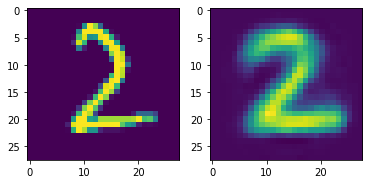

In [61]:
_, (image, label) = data.__next__()
plt.subplot(1, 2, 1)
plt.imshow(image[0][0])
plt.subplot(1, 2, 2)
model.to(device=device)
plt.imshow(model(image.to(device)).to('cpu').detach().numpy()[0][0])

In [63]:
vae_model_name = "models/vae.pth"
torch.save(model.state_dict(), vae_model_name)